# Working with the Twitter Search API

The goal of this notebook is to provide a strong demo of using the new python twitter search API wrapper to Do Data Science™.


Twitter data has a massive potential across many domains. What if you were curious about music patterns across the world? 



Let's get our notebook started with some imports and basic setup.

In [1]:
import os

import pandas as pd
import seaborn as sns

from tweet_parser.tweet import Tweet
from tweet_parser.getter_methods.tweet_geo import get_profile_location

from twittersearch.result_stream import ResultStream
from twittersearch.utils import *

# the following makes working in a notebook a bit easier, as you don't have to have new cells for all output
from IPython.display import HTML
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%load_ext autoreload
%autoreload 2
%matplotlib inline



## Using the API interactively

We'll define some high-level information here. For convenience, I've stored my password in an environemnt variable and we'll be using both the counts and search endpoints. I will generate the relevant arguments that we'll use for the rest of our session.

In [98]:
os.environ["TWITTER_SEARCH_ACCOUNT_NAME"] = ""
os.environ["TWITTER_SEARCH_PW"] = ""

In [4]:
username = "agonzales@twitter.com"
search_api = "fullarchive"
endpoint_label = "ogformat.json"

search_endpoint = gen_endpoint(search_api,
                               os.environ["TWITTER_SEARCH_ACCOUNT_NAME"],
                               endpoint_label,
                               count_endpoint=False)

count_endpoint = gen_endpoint(search_api,
                              os.environ["TWITTER_SEARCH_ACCOUNT_NAME"],
                              endpoint_label,
                              count_endpoint=True)

search_args = {"username": username,
               "password": os.environ["TWITTER_SEARCH_PW"],
               "url": search_endpoint }
count_args = {"username": username,
               "password": os.environ["TWITTER_SEARCH_PW"],
              "url": count_endpoint }


The power of the full-archive search api comes from the rich query language that it exposes to devleopers. Instead of manually filtering tweets from the free 1% streaming api, we can rapidly explore *all* tweets, all the way back to 

In [5]:
HTML('<blockquote class="twitter-tweet" data-lang="en"><p lang="en" dir="ltr">just setting up my twttr</p>&mdash; jack (@jack) <a href="https://twitter.com/jack/status/20">March 21, 2006</a></blockquote> <script async src="//platform.twitter.com/widgets.js" charset="utf-8"></script>')

The search API also has a `counts` endpoint, which instead of returning tweet data, returns the number of tweets that match your search critera that can be divied up into convenient buckets. quick explorations with the `count` endpoint can save you time and API calls.


Let's explore some tweets that mention musicians and how to make powertrack rules.

When using the helper method `gen_rule_payload`, you must define your powertrack rule. We'll start by matching tweets that mention "taylor swift" and use the counts api to refine our searches from there.

As a side note, in a notebook environemnt, i will break the DRY principle a bit.

In [6]:
_rule = """
"taylor swift"
"""


count_rule = gen_rule_payload(_rule,
                        from_date="2016-09-01",
                        to_date="2017-09-01",
                        max_results=500, 
                        count_bucket="day")

count_rule


'{"query": "\\"taylor swift\\"", "toDate": "201709010000", "fromDate": "201609010000", "bucket": "day"}'

Our main point of entry to the API is the `ResultStream` object and it's primary function, `.stream()`. We'll pass it our connection and authentication arguments, the jsonified rule payload, and either the `max_tweets` argument or the `max_pages` argument. By default, the `ResultStream` will paginate results from the API for you, but this parameter can effectively limit the number of calls used.

When using the Counts API, a single call returns a json array of count records, one per our defined count bucket. For our year-long range, a single call of 'day' buckets will get all the data we want.

In [7]:
count_stream = ResultStream(**count_args,
                           rule_payload=count_rule,
                           max_tweets=500)

The `ResultStream` object can be inspected with your various args. 

In [9]:
# print(count_stream)

The object has one main entry point, which returns a generator of results from the API. In many cases, you'll want to fetch all the results from this stream of data, which can be done as such:

In [10]:
count_results_gen = count_stream.stream()
count_results_gen

<generator object ResultStream.stream at 0x119d65468>

In [11]:
counts = list(count_results_gen)

As described earlier, we get back a quick count of tweets matching our rule in each bucket. We can quickly visualize this with Pandas:

In [12]:
counts[0]

{'count': 144445, 'timePeriod': '201708310000'}

In [14]:
def df_from_counts(counts):
    return (pd.DataFrame(counts)
             .assign(timePeriod=lambda df: pd.to_datetime(df["timePeriod"]))
             .set_index("timePeriod")
             .sort_index())

In [16]:
df_from_counts(counts).head()

count
timePeriod       
2016-09-01  20673
2016-09-02  18436
2016-09-03  20023
2016-09-04  19204
2016-09-05  20745

count    12166811
dtype: int64

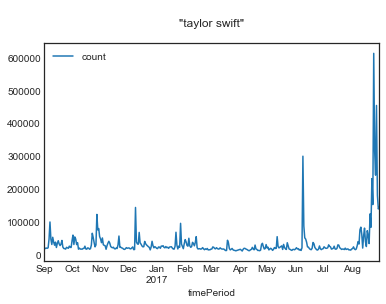

In [21]:
df_from_counts(counts).sum()
 
df_from_counts(counts).plot(title=_rule)

Alright, so there are 12 million matching tweets in our yearly history, with big spikes around the time Taylor does something newsworthy. We probably missed something here, which is that the exact match of "taylor swift" will miss all the mentions with her in them. Let's redo our search with a new rule.

In [22]:
_rule = """
"taylor swift" OR (has:mentions @taylorswift13)
"""


count_rule = gen_rule_payload(_rule,
                        from_date="2016-09-01",
                        to_date="2017-09-01",
                        max_results=500, 
                        count_bucket="day")

count_rule


'{"query": "\\"taylor swift\\" OR (has:mentions @taylorswift13)", "toDate": "201709010000", "fromDate": "201609010000", "bucket": "day"}'

We can shorten our previous interaction with the `ResultStream` object to something like this:

In [23]:
counts = list(ResultStream(**count_args,
                           rule_payload=count_rule,
                           max_tweets=500)
              .stream())

count    17401215
dtype: int64

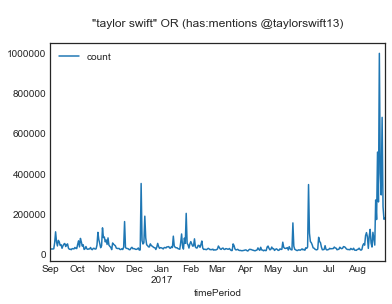

In [24]:
df_from_counts(counts).sum()
 
df_from_counts(counts).plot(title=_rule)

Great, so we get similar patterns of tweets, but have an additional ~5 million with which we can work, and we haven't began including other things people might mention about her, such as her album or song names, or phrases like "I'm listening to tswift's new album". Let's add in her common nickname to the counts on more time:

In [25]:
_rule = """
"taylor swift"
OR (has:mentions @taylorswift13)
OR "tswift"
"""


count_rule = gen_rule_payload(_rule,
                        from_date="2016-09-01",
                        to_date="2017-09-01",
                        max_results=500, 
                        count_bucket="day")

count_rule


'{"query": "\\"taylor swift\\" OR (has:mentions @taylorswift13) OR \\"tswift\\"", "toDate": "201709010000", "fromDate": "201609010000", "bucket": "day"}'

In [26]:
counts = list(ResultStream(**count_args,
                           rule_payload=count_rule,
                           max_tweets=500)
              .stream())

count    17530675
dtype: int64

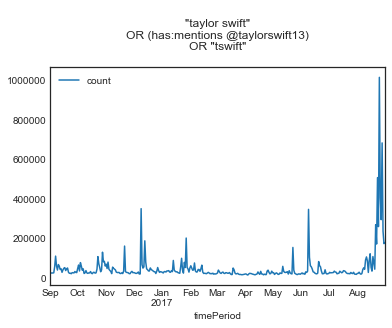

In [27]:
df_from_counts(counts).sum()
 
df_from_counts(counts).plot(title=_rule)

Hardly any difference, so let's move on. 

Powertrack rules also allow you to find tweets that have explicit information, such as geographical location data. We'll want to examine regional differences in music patterns, so let's see how many of our tweets have that data using the `has:geo` operator. 

Note that geo tags are turned OFF by default, so there are usually FAR fewer tweets that have geo information than those without. We offer a `profile_geo` operator that will expose the home geo of the user, which can be a very reasonable proxy for tweet geo in many cases.

In [28]:
_rule = """
("taylor swift" OR (has:mentions @taylorswift13) OR "tswift")
has:geo
"""


count_rule = gen_rule_payload(_rule,
                        from_date="2016-09-01",
                        to_date="2017-09-01",
                        max_results=500, 
                        count_bucket="day")

count_rule

'{"query": "(\\"taylor swift\\" OR (has:mentions @taylorswift13) OR \\"tswift\\") has:geo", "toDate": "201709010000", "fromDate": "201609010000", "bucket": "day"}'

In [29]:
counts = list(ResultStream(**count_args,
                           rule_payload=count_rule,
                           max_tweets=500)
              .stream())

count    243015
dtype: int64

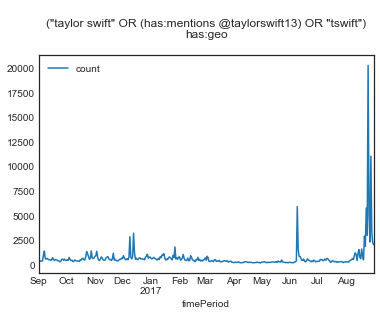

In [30]:
df_from_counts(counts).sum()
 
df_from_counts(counts).plot(title=_rule)

As mentioned, we have wildly fewer tweets that match our criteria, but let's see what we can do with the `profile_geo` enrichment.

In [31]:
_rule = """
("taylor swift" OR (has:mentions @taylorswift13) OR "tswift")
(has:geo
OR
has:profile_geo)
"""


count_rule = gen_rule_payload(_rule,
                        from_date="2016-09-01",
                        to_date="2017-09-01",
                        max_results=500, 
                        count_bucket="day")

count_rule

'{"query": "(\\"taylor swift\\" OR (has:mentions @taylorswift13) OR \\"tswift\\") (has:geo OR has:profile_geo)", "toDate": "201709010000", "fromDate": "201609010000", "bucket": "day"}'

In [32]:
counts = list(ResultStream(**count_args,
                           rule_payload=count_rule,
                           max_tweets=500)
              .stream())

retrying request; current status code: 503


count    7931434
dtype: int64

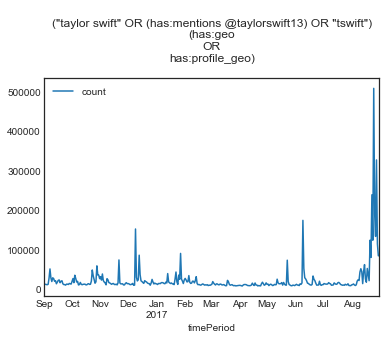

In [33]:
df_from_counts(counts).sum()
 
df_from_counts(counts).plot(title=_rule)

What if we want to ensure these tweets are not retweets? We can add the `-is:retweet` operator to mix:

In [77]:
_rule = """
("taylor swift" OR (has:mentions @taylorswift13) OR "tswift")
(has:geo
OR
has:profile_geo)
-is:retweet
"""


count_rule = gen_rule_payload(_rule,
                        from_date="2016-09-01",
                        to_date="2017-09-01",
                        max_results=500, 
                        count_bucket="day")

count_rule

'{"query": "(\\"taylor swift\\" OR (has:mentions @taylorswift13) OR \\"tswift\\") (has:geo OR has:profile_geo) -is:retweet", "toDate": "201709010000", "fromDate": "201609010000", "bucket": "day"}'

In [78]:
counts = list(ResultStream(**count_args,
                           rule_payload=count_rule,
                           max_tweets=500)
              .stream())

count    2926543
dtype: int64

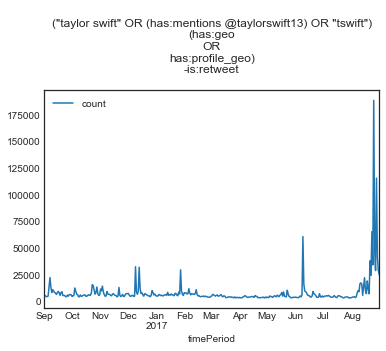

In [79]:
df_from_counts(counts).sum()
 
df_from_counts(counts).plot(title=_rule)

In [34]:
_rule = """
("taylor swift" OR (has:mentions @taylorswift13) OR "tswift")
has:geo
"""


search_rule = gen_rule_payload(_rule,
                               from_date="2016-09-01",
                               to_date="2017-09-01",
                               max_results=500
                              )

search_rule

'{"query": "(\\"taylor swift\\" OR (has:mentions @taylorswift13) OR \\"tswift\\") has:geo", "maxResults": 500, "toDate": "201709010000", "fromDate": "201609010000"}'

In [35]:
tweets = list(ResultStream(**search_args, rule_payload=search_rule, max_tweets=500)
              .stream())

With the python interface to the search API, tweets are automatically parsed via the [Tweet_parser library](https://github.com/tw-ddis/tweet_parser), which makes working with them fairly straightforward. We've abstracted out many of the annoying details of working with raw tweet data and provided a straightforward API with access to lots of tweet data. Let's take a look:

In [38]:
t = tweets[0]
t.created_at_datetime
t.bio
t.text


t["place"]


datetime.datetime(2017, 8, 31, 23, 59, 24)

'to no tuiter pra reclamar'

'Me perdoe pai, mas eu pequei! Não consigo parar de escutar a nova música da Taylor Swift!!!'

{'attributes': {},
 'bounding_box': {'coordinates': [[[-43.795449, -23.08302],
    [-43.795449, -22.739823],
    [-43.087707, -22.739823],
    [-43.087707, -23.08302]]],
  'type': 'Polygon'},
 'country': 'Brazil',
 'country_code': 'BR',
 'full_name': 'Rio de Janeiro, Brazil',
 'id': '97bcdfca1a2dca59',
 'name': 'Rio de Janeiro',
 'place_type': 'city',
 'url': 'https://api.twitter.com/1.1/geo/id/97bcdfca1a2dca59.json'}

this person doesn't seem to care much for Taylor's new music. (Shrug).


Before we move on, we'll pause to define a few functions that will help with grabbing the geojson data from a tweet. Recall that the `has:geo` operator will return tweets that are tagged at a Twitter-defined `Place` (in this case, the city of Coralville, IA). Places are given a bounding box, which may not be useful for your application (i have a map in mind...).

We cannot cover all use cases for the tweet parser, but it's easily extentible, or you can use methods that work on dicts because each tweet is really a subclass of `dict`. 

To demonstrate the need for this here, let's grab tweets that have *exact* coordinates:

In [39]:
[t.geo_coordinates for t in tweets if t.geo_coordinates] 

[{'latitude': -20.2814932, 'longitude': -40.3020038},
 {'latitude': 37.7879295, 'longitude': -122.4075012},
 {'latitude': -23.56138889, 'longitude': -46.65638889},
 {'latitude': 53.01144825, 'longitude': -6.32534922},
 {'latitude': 39.7591363, 'longitude': -121.8159693},
 {'latitude': -0.8966, 'longitude': 100.41911}]

if we are going to generate a map or work with single coordinates, we'll have to turn boudning boxes into sigular points and have a single function that extracts the geo data from each tweet.


Note - the coordinates are returned as [LONG, LAT], and in the parsing functions, I will flip those to the required downstream format [LAT, LONG].

In [40]:
from functools import reduce

from tweet_parser.tweet_checking import is_original_format

try:
    import numpy as np
    mean_bbox = lambda x: list(np.array(x).mean(axis=0))
except ImportError:
    mean_bbox = lambda x: (reduce(lambda y, z: y + z, x) / len(x))

def get_profile_geo_coords(tweet):
    geo = tweet.profile_location.get("geo")
    coords = geo.get("coordinates") # in [LONG, LAT]
    if coords:
        long, lat = coords
    return lat, long


def get_place_coords(tweet, est_center=False):
    """
    Places are formal spots that define a bounding box around a place.
    Each coordinate pair in the bounding box is a set of [[lat, long], [lat, long]]
    pairs.
    
    """
    
    def get_bbox_ogformat():
        _place = tweet.get("place")
        if _place is None:
            return None
    
        return (_place
                .get("bounding_box")
                .get("coordinates")[0])

    def get_bbox_asformat():
        _place = tweet.get("location")
        if _place is None:
            return None
        return (_place
                .get("geo")
                .get("coordinates")[0])
        
    bbox = get_bbox_ogformat() if is_original_format(tweet) else get_bbox_asformat()

    return mean_bbox(bbox) if est_center else bbox


def get_exact_geo_coords(tweet):
    geo = tweet.get("geo")
    if geo is None:
        return None
    
    # coordinates.coordinates is [LONG, LAT]
    # geo.coordinates is [LAT, LONG]
    field = "geo" if is_original_format(tweet) else "geo"
    coords = tweet.get("geo").get("coordinates")
    return coords


def get_a_geo_coordinate(tweet):
    geo = get_exact_geo_coords(tweet)
    lat, long = geo if geo else (None, None)
    if lat:
        return lat, long
    long, lat = get_place_coords(tweet, est_center=True)
    return lat, long

In [41]:
get_a_geo_coordinate(t)
t["place"]

(-22.911421500000003, -43.441578)

{'attributes': {},
 'bounding_box': {'coordinates': [[[-43.795449, -23.08302],
    [-43.795449, -22.739823],
    [-43.087707, -22.739823],
    [-43.087707, -23.08302]]],
  'type': 'Polygon'},
 'country': 'Brazil',
 'country_code': 'BR',
 'full_name': 'Rio de Janeiro, Brazil',
 'id': '97bcdfca1a2dca59',
 'name': 'Rio de Janeiro',
 'place_type': 'city',
 'url': 'https://api.twitter.com/1.1/geo/id/97bcdfca1a2dca59.json'}

Our highest function will grab the center of a bounding box. This works really well when we have a city-or-smaller place and is not as useful for a profile geo of "Texas", but so it goes.


## Working with the tweet stream / Let's build a map


Given the streaming format of tweets that is returned by our api, we can pull large amounts of data interactively and build functions that help organize it to our needs directly. 

As this example is going to eventually go beyond Taylor Swift, we'll define a wrapper function that takes an input ResultStream object and returns a pandas dataframe with our geo coordinate information and other basic information from tweets. it will correctly filter and index the dataframe, giving us something back that we can rapidly use to Make Maps. We'll use another utility function that converts the [lat, long] pairs to web mercator format ([meters_x, meters_y]) format that is required by some plotting libraries. I lightly adapted this from an example in Datashader.

In [42]:
def latlng_to_meters(df, lat_name, lng_name):
    """
    Taken and modified from the datashader notebooks 
    """
    lat = df[lat_name]
    lng = df[lng_name]
    origin_shift = 2 * np.pi * 6378137 / 2.0
    mx = lng * origin_shift / 180.0
    my = np.log(np.tan((90 + lat) * np.pi / 360.0)) / (np.pi / 180.0)
    my = my * origin_shift / 180.0
    return df.assign(mx=mx).assign(my=my)

In [43]:
def tweet_geo_collector(result_stream, tag, fields=None):
    if fields is None:
        fields = ["id", "created_at_datetime", "text"]
    
    coords = []
    print("collecting tweets for {}".format(tag))
    for tweet in result_stream.stream():
        attrs = (tweet.__getattribute__(field)
                   for field in fields)
        try:
            _coords = get_a_geo_coordinate(tweet)
            coords.append(list(it.chain.from_iterable([attrs, _coords])))
        except AttributeError:
            print("error in geo")
            print(tweet.id, tweet.text)
            continue
        
        
    columns = list(it.chain.from_iterable([fields, ["lat", "long"]]))
    
    df = (pd.DataFrame(coords, columns=columns)
          .pipe(latlng_to_meters, "lat", "long")
          .drop(["lat", "long"], axis=1)
          .assign(tag=tag)
         )
    return df



In [44]:
rs = ResultStream(**search_args, rule_payload=search_rule, max_tweets=2000)
# rs.artist = "taylor_swift"
df = tweet_geo_collector(rs, tag="taylor_swift")

collecting tweets for taylor_swift


In [45]:
df.head()
df.info()

id created_at_datetime  \
0  903406902394183680 2017-08-31 23:59:24   
1  903406724790579200 2017-08-31 23:58:42   
2  903406371307044864 2017-08-31 23:57:18   
3  903406241178718208 2017-08-31 23:56:47   
4  903406238267916288 2017-08-31 23:56:46   

                                                text            mx  \
0  Me perdoe pai, mas eu pequei! Não consigo para... -4.835894e+06   
1                        Y'all sleep on Taylor Swift -1.114051e+07   
2  @JamesEdwardII Yo, quit being weird as shit. J... -1.246018e+07   
3                     taylor swift blames the healer  1.541228e+07   
4  @danozzi Quite the contrary. We need more Tayl... -1.365624e+07   

             my           tag  
0 -2.621310e+06  taylor_swift  
1  3.654703e+06  taylor_swift  
2  4.051417e+06  taylor_swift  
3  4.135125e+06  taylor_swift  
4  4.643507e+06  taylor_swift

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 6 columns):
id                     2000 non-null object
created_at_datetime    2000 non-null datetime64[ns]
text                   2000 non-null object
mx                     2000 non-null float64
my                     2000 non-null float64
tag                    2000 non-null object
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 93.8+ KB


In [46]:
(df
 .set_index("created_at_datetime")
 .sort_index()
 .resample("D")
 .size()
)

created_at_datetime
2017-08-30      62
2017-08-31    1938
Freq: D, dtype: int64

We'll use Bokeh to do some plotting:

In [47]:
from functools import partial


from bokeh.models import WMTSTileSource
from bokeh.tile_providers import STAMEN_TONER

from bokeh.io import output_notebook, show
from bokeh.plotting import ColumnDataSource, figure
from bokeh.models import HoverTool, value

output_notebook()

tiles = {'OpenMap': WMTSTileSource(url='http://c.tile.openstreetmap.org/{Z}/{X}/{Y}.png'),
         'ESRI': WMTSTileSource(url='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{Z}/{Y}/{X}.jpg'),
         'Wikipedia': WMTSTileSource(url='https://maps.wikimedia.org/osm-intl/{Z}/{X}/{Y}@2x.png'),
         'Stamen': WMTSTileSource(url="http://tile.stamen.com/toner-background/{z}/{x}/{y}.png", )
         }


def plot_tweets(df, x_col="mx", y_col="my", tile="Stamen", title="title"):
    # add our DataFrame as a ColumnDataSource for Bokeh
    plot_data = ColumnDataSource(df)
    # create the plot and configure the
    # title, dimensions, and tools
    plot = figure(title=title,
                  plot_width=800,
                  plot_height=800,
                  tools= ('pan, wheel_zoom, box_zoom, reset'),
                  active_scroll='wheel_zoom')

    # add a hover tool to display words on roll-over
    plot.add_tools(HoverTool(tooltips = '@text'))

    # draw the words as circles on the plot
    plot.circle(x=x_col, y=y_col, source=plot_data,
                     color=u'blue', line_alpha=0.1, fill_alpha=0.1,
                     size=3, hover_line_color='black')

    # configure visual elements of the plot
    plot.title.text_font_size = value('12pt')
    plot.xaxis.visible = False
    plot.yaxis.visible = False
    plot.grid.grid_line_color = None
    plot.outline_line_color = None
    plot.add_tile(tiles[tile], alpha=0.25)
    return plot



Loading BokehJS ...

In [48]:
show(plot_tweets(df, title=json.loads(search_rule)["query"]))

So, wrapping up the first section, we have an interactive map of where tweets that mention taylor-swift related terms in very little code. 


We'll scale up in the next section by adding both 
- more tweets
- more artists

## Dynamically generating rules

In [80]:
base_rule = """
(("{exact_name}") OR (has:mentions @{handle}))
has:geo
-is:retweet
"""


from functools import partial


gen_search_payload_ = partial(gen_rule_payload,
                            max_results=500,
                            from_date="2016-09-01",
                            to_date="2017-09-01",
                            )

gen_count_payload_ = partial(gen_rule_payload,
                            max_results=500,
                            from_date="2016-09-01",
                            to_date="2017-09-01",
                            count_bucket='day'
                            )





artists_names = [
                 "beyonce",
                 "lady gaga",
                 "taylor swift",
                "rihanna",
                ]

artists = {
           "beyonce": "beyonce",
           "lady gaga": "ladygaga",
           "taylor swift": "taylorswift13",
           "rihanna": "rihanna"
          }


artist_count_rules = [gen_count_payload_(base_rule.format(exact_name=name, handle=handle))
                for name, handle in artists.items()]
artist_search_rules = [gen_search_payload_(base_rule.format(exact_name=name, handle=handle))
                for name, handle in artists.items()]

In [86]:
print(artist_count_rules[0])

{"query": "((\"beyonce\") OR (has:mentions @beyonce)) has:geo -is:retweet", "toDate": "201709010000", "fromDate": "201609010000", "bucket": "day"}


In [87]:
streams = [ResultStream(**count_args,
                        rule_payload=rule,
                        max_tweets=500)
           for rule in artist_count_rules]



In [88]:
df_from_counts = lambda x: (pd.DataFrame(x)
                             .assign(timePeriod=lambda df: pd.to_datetime(df["timePeriod"]))
                             .set_index("timePeriod")
                             .sort_index())

counts = (pd.concat([df_from_counts(list(rs.stream())).assign(artist=artist)
                    for rs, artist in zip(streams, artists_names)])
         )

In [89]:
counts = (counts
          .reset_index()
          .set_index(["timePeriod", "artist"])
          .sort_index()
          .unstack()["count"])

artist      beyonce  lady gaga  rihanna  taylor swift
timePeriod                                           
2016-09-01     1399        681     3065           412
2016-09-02     1306        413     1919           346
2016-09-03     1301        259     1307           361
2016-09-04     7358        363     2060           320
2016-09-05     2784        378     1652           376

artist
beyonce         426449
lady gaga       305258
rihanna         311047
taylor swift    236735
dtype: int64

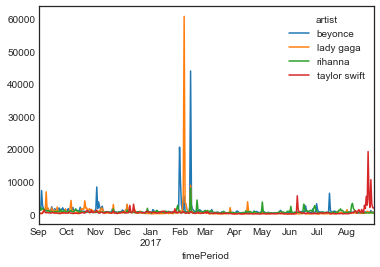

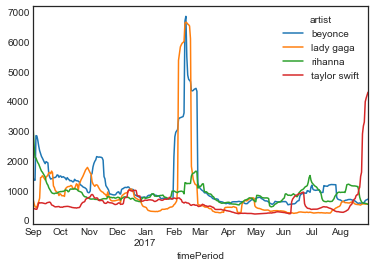

In [90]:
counts.head()

counts.sum()
counts.plot()
counts.rolling("14D").mean().plot()

In [91]:
streams = [ResultStream(**search_args,
                        rule_payload=rule,
                        max_tweets=2500)
           for rule in artist_search_rules]

In [92]:
results = [tweet_geo_collector(stream, tag)
           for stream, tag in zip(streams, artists.keys())]

collecting tweets for beyonce
collecting tweets for lady gaga
collecting tweets for taylor swift
collecting tweets for rihanna


In [93]:
df = pd.concat(results)

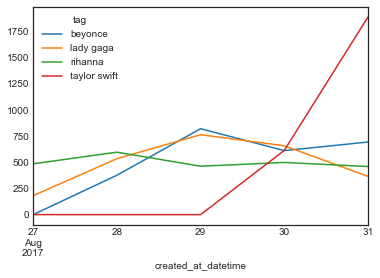

In [94]:
(df
 .set_index("created_at_datetime")
 .sort_index()
 .groupby([pd.TimeGrouper("D"), "tag"])
 .size()
 .to_frame("tweets")
 ["tweets"]
 .unstack()
 .fillna(0)
 .plot()
 
)

In [70]:
from bokeh.models.widgets import Panel, Tabs

In [95]:
tabs = []
for artist in artists.keys():
    panel = Panel(child=plot_tweets(df.query("tag == @artist"),
                              title=artist),
                  title=artist)
    tabs.append(panel)
    
                  
                  
    

tabs = Tabs(tabs=tabs)

In [97]:
show(tabs)

## Datashader

/Users/agonzales/anaconda3/envs/holo/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)



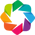

In [99]:
from bokeh import palettes

import datashader as ds
import datashader.transfer_functions as tf

from datashader.bokeh_ext import InteractiveImage

from cartopy import crs


import geoviews as gv

import holoviews as hv

from holoviews.operation.datashader import aggregate, shade, datashade, dynspread


hv.notebook_extension('mpl', 'bokeh')


def gen_col_points(categories, colormap):
    inv_cats = {k: k for k in categories}
    color_points = hv.NdOverlay({inv_cats[k]: gv.Points([0,0],
                                                        crs=crs.PlateCarree(),
                                                        label=inv_cats[k])
                                 (style=dict(color=v))
                                 for k, v in colormap.items()})
    return color_points

In [106]:
20000 / 500 * 4

160.0

In [107]:
streams = [ResultStream(**search_args,
                        rule_payload=rule,
                        max_tweets=20000)
           for rule in artist_search_rules]

In [108]:
results = [tweet_geo_collector(stream, tag)
           for stream, tag in zip(streams, artists.keys())]

collecting tweets for beyonce


INFO:twittersearch.result_stream:paging; total requests read so far: 1
INFO:twittersearch.result_stream:paging; total requests read so far: 2
INFO:twittersearch.result_stream:paging; total requests read so far: 3
INFO:twittersearch.result_stream:paging; total requests read so far: 4
INFO:twittersearch.result_stream:paging; total requests read so far: 5
INFO:twittersearch.result_stream:paging; total requests read so far: 6
INFO:twittersearch.result_stream:paging; total requests read so far: 7
INFO:twittersearch.result_stream:paging; total requests read so far: 8
INFO:twittersearch.result_stream:paging; total requests read so far: 9
INFO:twittersearch.result_stream:paging; total requests read so far: 10
INFO:twittersearch.result_stream:paging; total requests read so far: 11
INFO:twittersearch.result_stream:paging; total requests read so far: 12
INFO:twittersearch.result_stream:paging; total requests read so far: 13
INFO:twittersearch.result_stream:paging; total requests read so far: 14
I

collecting tweets for lady gaga


INFO:twittersearch.result_stream:paging; total requests read so far: 1
INFO:twittersearch.result_stream:paging; total requests read so far: 2
INFO:twittersearch.result_stream:paging; total requests read so far: 3
INFO:twittersearch.result_stream:paging; total requests read so far: 4
INFO:twittersearch.result_stream:paging; total requests read so far: 5
INFO:twittersearch.result_stream:paging; total requests read so far: 6
INFO:twittersearch.result_stream:paging; total requests read so far: 7
INFO:twittersearch.result_stream:paging; total requests read so far: 8
INFO:twittersearch.result_stream:paging; total requests read so far: 9
INFO:twittersearch.result_stream:paging; total requests read so far: 10
INFO:twittersearch.result_stream:paging; total requests read so far: 11
INFO:twittersearch.result_stream:paging; total requests read so far: 12
INFO:twittersearch.result_stream:paging; total requests read so far: 13
INFO:twittersearch.result_stream:paging; total requests read so far: 14
I

collecting tweets for taylor swift


INFO:twittersearch.result_stream:paging; total requests read so far: 1
INFO:twittersearch.result_stream:paging; total requests read so far: 2
INFO:twittersearch.result_stream:paging; total requests read so far: 3
INFO:twittersearch.result_stream:paging; total requests read so far: 4
INFO:twittersearch.result_stream:paging; total requests read so far: 5
INFO:twittersearch.result_stream:paging; total requests read so far: 6
INFO:twittersearch.result_stream:paging; total requests read so far: 7
INFO:twittersearch.result_stream:paging; total requests read so far: 8
INFO:twittersearch.result_stream:paging; total requests read so far: 9
INFO:twittersearch.result_stream:paging; total requests read so far: 10
INFO:twittersearch.result_stream:paging; total requests read so far: 11
INFO:twittersearch.result_stream:paging; total requests read so far: 12
INFO:twittersearch.result_stream:paging; total requests read so far: 13
INFO:twittersearch.result_stream:paging; total requests read so far: 14
I

collecting tweets for rihanna


INFO:twittersearch.result_stream:paging; total requests read so far: 1
INFO:twittersearch.result_stream:paging; total requests read so far: 2
INFO:twittersearch.result_stream:paging; total requests read so far: 3
INFO:twittersearch.result_stream:paging; total requests read so far: 4
INFO:twittersearch.result_stream:paging; total requests read so far: 5
INFO:twittersearch.result_stream:paging; total requests read so far: 6
INFO:twittersearch.result_stream:paging; total requests read so far: 7
INFO:twittersearch.result_stream:paging; total requests read so far: 8
INFO:twittersearch.result_stream:paging; total requests read so far: 9
INFO:twittersearch.result_stream:paging; total requests read so far: 10
INFO:twittersearch.result_stream:paging; total requests read so far: 11
INFO:twittersearch.result_stream:paging; total requests read so far: 12
INFO:twittersearch.result_stream:paging; total requests read so far: 13
INFO:twittersearch.result_stream:paging; total requests read so far: 14
I

In [109]:
plot_df = (pd.concat(results)
           .assign(tag=lambda df: df["tag"].astype("category"))
          )

In [111]:
x_min, y_min, x_max, y_max = (plot_df.mx.values.min(),
                              plot_df.my.values.min(),
                              plot_df.mx.values.max(),
                              plot_df.my.values.max())
x_range=(x_min, x_max)
y_range=(y_min, y_max)
color_key = dict(zip(artists, palettes.Category10[len(artists)]))
shade_defaults = dict(x_range=x_range,
                      y_range=y_range,
                      width=1200,
                      height=660)

In [112]:
%%output filename="artist_datashaded_points"
%%opts Overlay [width=800 height=600 xaxis=None yaxis=None show_grid=False ] (background_alpha=0.1) 
%%opts Shape (fill_color=None line_width=1.5) [apply_ranges=False] 
%%opts Points [apply_ranges=False tools=[]]
%%opts WMTS (alpha=0.25)


shaded_points = datashade(hv.Points(gv.Dataset(plot_df,
                                               kdims=["mx", "my"],
                                               vdims=["tag"])),
                          cmap=color_key,
                          element_type=gv.Image,
                          aggregator=ds.count_cat("tag"),
                          **shade_defaults, 
                         )

color_points = gen_col_points(color_key.keys(), color_key)

map_ = gv.WMTS(tiles["Stamen"]) * dynspread(shaded_points,
                                            max_px=1,
                                            threshold=0.5) * color_points
map_

:DynamicMap   []